In [1]:
# This file generates the data for Figure #4 from the paper https://arxiv.org/pdf/1806.06975.pdf
import sys
sys.path.append('../')

import os
import sys
import pickle
import argparse
import networkx as nx

import pandas as pd
import numpy as np

import itertools
import sklearn
import torch
import datetime
import matplotlib, matplotlib.pyplot as plt

from torch.autograd import Variable

from models.mlp import MLP
from data import datasets
from data.gene_graphs import GeneManiaGraph, RegNetGraph
from data.utils import record_result

In [2]:
dataset = datasets.TCGADataset()
dataset.df = dataset.df - dataset.df.mean(axis=0)

Converting one-hot labels to integers


In [3]:
graphs = {"regnet": RegNetGraph(), "genemania": GeneManiaGraph()}


In [4]:
# Setup the results dictionary
filename = "experiments/results/fig-4.pkl"
try:
    results = pickle.load(open(filename, "rb"), encoding='latin1')
    print("Loaded Checkpointed Results")
except Exception as e:
    print(e)
    results = pd.DataFrame(columns=['auc', 'gene', 'model', 'graph', 'is_first_degree', 'seed', 'train_size'])
    print("Created a New Results Dictionary")


Loaded Checkpointed Results


In [6]:
train_size = 50
test_size = 1000
trials = 3
cuda = torch.cuda.is_available()
models = {"BasicMLP": MLP(column_names=dataset.df.columns, dropout=False, cuda=cuda)}


Early stopping metric is accuracy_score


In [7]:
# Create the set of all experiment ids and see which are left to do
columns = ["gene", "graph", "model", "seed", "is_first_degree", "train_size"]
all_exp_ids = [x for x in itertools.product(dataset.df.columns, graphs.keys(), models.keys(), range(trials), [True, False], [train_size])]
all_exp_ids = pd.DataFrame(all_exp_ids, columns=columns)
all_exp_ids.index = ["-".join(map(str, tup[1:])) for tup in all_exp_ids.itertuples(name=None)]
results_exp_ids = results[columns].copy()
results_exp_ids.index = ["-".join(map(str, tup[1:])) for tup in results_exp_ids.itertuples(name=None)]
intersection_ids = all_exp_ids.index.intersection(results_exp_ids.index)
todo = all_exp_ids.drop(intersection_ids).to_dict(orient="records")

print("todo: " + str(len(todo)))
print("done: " + str(len(results)))

todo: 195582
done: 33


In [8]:
for row in todo:
    if len(results) % 10 == 0:
        print(len(results))
    gene = row["gene"]
    graph_name = row["graph"]
    model_name = row["model"]
    seed = row["seed"]
    is_first_degree = row["is_first_degree"]
    model = models[model_name]

    experiment = {
        "gene": gene,
        "model": model_name,
        "graph": graph_name,
        "is_first_degree": is_first_degree,
        "seed": seed,
        "train_size": train_size,
    }
    dataset.labels = dataset.df[gene].where(dataset.df[gene] > 0).notnull().astype("int")
    dataset.labels = dataset.labels.values if type(dataset.labels) == pd.Series else dataset.labels

    try:
        X_train, X_test, y_train, y_test = sklearn.model_selection.\
            train_test_split(dataset.df, dataset.labels, stratify=dataset.labels, 
                             train_size=train_size, test_size=test_size)
    except ValueError:
        results = record_result(results, experiment, filename)
        continue
    if is_first_degree:
        gene_graph = graphs[graph_name]
        neighbors = list(gene_graph.first_degree(gene)[0])
        neighbors = [n for n in neighbors if n in X_train.columns.values]
        X_train = X_train.loc[:, neighbors].copy()
        X_test = X_test.loc[:, neighbors].copy()
    else:
        X_train = X_train.copy()
        X_test = X_test.copy()
    X_train[gene] = 1
    X_test[gene] = 1
    import pdb; pdb.set_trace()
    try:
        model.fit(X_train, y_train)
        if cuda:
            X_test = X_test.cuda()
        y_hat = model.predict(X_test)
        auc = sklearn.metrics.roc_auc_score(y_test, np.asarray(y_hat).flatten())
        model.best_model = None # cleanup
        experiment["auc"] = auc
    except Exception as e:
        print(e)
    results = record_result(results, experiment, filename)


> <ipython-input-8-3986c454a6da>(39)<module>()
-> try:


(Pdb)  X_test


         UBE2D3     PCDH1    SMURF1    PNPLA7     NCOA4     HNF1A     NR3C1  \
7246  -0.473352  2.653886  0.946980 -0.294421  0.438716  4.123668 -1.566019   
821    0.051548 -4.321514 -1.341520 -2.936721 -2.021585 -0.445932 -0.274519   
10189 -0.715652  0.561687  0.186680 -1.977421 -0.080585  0.162467 -1.568519   
8087   0.158547 -3.364014 -2.395320  3.334679 -1.703884 -2.890832 -0.369419   
8947  -0.365052  2.431186  1.078880 -2.312421  0.690215 -0.453332 -0.034819   
5434  -0.743953  1.376786  0.234780 -0.631521  0.516416 -0.228033 -1.254418   
1161  -0.113452  0.204886 -0.197420 -0.432721  0.487915 -1.538133  0.443981   
2644   0.212748  2.039586 -0.115820 -0.251521 -0.194684  3.905567 -3.739919   
1833  -0.463552  0.190286 -0.175820  0.399179 -0.153484 -0.716033  0.576081   
4223  -0.144452 -0.123414 -0.234420  3.746879  0.854416 -1.706632  0.697381   
3217  -0.345153 -2.728614 -0.480220 -0.337821  0.352316 -0.880932  0.960781   
6708  -0.122602 -0.057514 -0.542920  0.856429 -0.451

(Pdb)  l


 34  	        X_train = X_train.copy()
 35  	        X_test = X_test.copy()
 36  	    X_train[gene] = 1
 37  	    X_test[gene] = 1
 38  	    import pdb; pdb.set_trace()
 39  ->	    try:
 40  	        model.fit(X_train, y_train)
 41  	        if cuda:
 42  	            X_test = X_test.cuda()
 43  	        y_hat = model.predict(X_test)
 44  	        auc = sklearn.metrics.roc_auc_score(y_test, np.asarray(y_hat).flatten())


(Pdb)  n


> <ipython-input-8-3986c454a6da>(40)<module>()
-> model.fit(X_train, y_train)


(Pdb)  s


--Call--
> /Users/martinweiss/code/academic/gene-graph-conv/models/models.py(49)fit()
-> def fit(self, X, y, adj=None):


(Pdb)  n


> /Users/martinweiss/code/academic/gene-graph-conv/models/models.py(50)fit()
-> self.adj = adj


(Pdb)  


> /Users/martinweiss/code/academic/gene-graph-conv/models/models.py(51)fit()
-> self.X = X


(Pdb)  


> /Users/martinweiss/code/academic/gene-graph-conv/models/models.py(52)fit()
-> self.y = y


(Pdb)  


> /Users/martinweiss/code/academic/gene-graph-conv/models/models.py(53)fit()
-> start = time.time()


(Pdb)  


> /Users/martinweiss/code/academic/gene-graph-conv/models/models.py(54)fit()
-> self.setup_layers()


(Pdb)  


> /Users/martinweiss/code/academic/gene-graph-conv/models/models.py(55)fit()
-> self.adj = None


(Pdb)  


> /Users/martinweiss/code/academic/gene-graph-conv/models/models.py(56)fit()
-> self.X = None


(Pdb)  


> /Users/martinweiss/code/academic/gene-graph-conv/models/models.py(57)fit()
-> x_train, x_valid, y_train, y_valid = sklearn.model_selection.train_test_split(X, y, stratify=y, train_size=self.train_valid_split, test_size=1-self.train_valid_split, random_state=self.seed)


(Pdb)  


> /Users/martinweiss/code/academic/gene-graph-conv/models/models.py(59)fit()
-> x_train = torch.FloatTensor(np.expand_dims(x_train, axis=2))


(Pdb)  


> /Users/martinweiss/code/academic/gene-graph-conv/models/models.py(60)fit()
-> x_valid = torch.FloatTensor(np.expand_dims(x_valid, axis=2))


(Pdb)  


> /Users/martinweiss/code/academic/gene-graph-conv/models/models.py(61)fit()
-> y_train = torch.FloatTensor(y_train)


(Pdb)  


ValueError: could not determine the shape of object type 'Series'
> /Users/martinweiss/code/academic/gene-graph-conv/models/models.py(61)fit()
-> y_train = torch.FloatTensor(y_train)


(Pdb)  y_train


5152    1
6233    1
2565    1
4346    1
4152    0
4316    0
8434    0
8258    1
3937    1
7357    0
3032    1
6981    0
8624    0
1582    1
4119    0
2290    1
9702    0
9070    1
8123    0
7192    1
7941    0
239     1
8936    0
7263    1
7315    0
9910    0
269     1
2451    0
197     0
7020    0
1619    1
9693    0
2685    1
2714    0
3317    1
4971    1
1156    0
8957    1
310     1
7330    0
Name: RNF14, dtype: int64


(Pdb)  y_train.numpy()


*** AttributeError: 'Series' object has no attribute 'numpy'


(Pdb)  y_train.values


array([1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0])


(Pdb)  l


 56  	        self.X = None
 57  	        x_train, x_valid, y_train, y_valid = sklearn.model_selection.train_test_split(X, y, stratify=y, train_size=self.train_valid_split, test_size=1-self.train_valid_split, random_state=self.seed)
 58  	
 59  	        x_train = torch.FloatTensor(np.expand_dims(x_train, axis=2))
 60  	        x_valid = torch.FloatTensor(np.expand_dims(x_valid, axis=2))
 61  ->	        y_train = torch.FloatTensor(y_train)
 62  	
 63  	        criterion = torch.nn.CrossEntropyLoss(reduction='mean')
 64  	        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=0.0001)
 65  	        if self.scheduler:
 66  	            scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.9)


(Pdb)  q



> <ipython-input-8-3986c454a6da>(38)<module>()
-> import pdb; pdb.set_trace()


(Pdb)  q


BdbQuit: 

In [ ]:
# Compare the performance of each graph at predicting their neighbors
df = results

first_degree = df[df['is_first_degree'] == True][
    df['graph'] == 'genemania'].groupby(['gene', 'model', 'train_size'])['auc'].agg(['mean', 'std'])
full = df[df['is_first_degree'] == False][
    df['graph'] == 'genemania'].groupby(['gene','model', 'train_size'])['auc'].agg(['mean', 'std'])
genemania_df = first_degree.sub(full).sort_values('mean', ascending=False)

first_degree = df[df['is_first_degree'] == True][
    df['graph'] == 'regnet'].groupby(['gene', 'model', 'train_size'])['auc'].agg(['mean', 'std'])
full = df[df['is_first_degree'] == False][
    df['graph'] == 'regnet'].groupby(['gene','model', 'train_size'])['auc'].agg(['mean', 'std'])
regnet_df = first_degree.sub(full).sort_values('mean', ascending=False)


/home/martin/code/academic/gene-graph-conv/venv/lib/python3.5/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/martin/code/academic/gene-graph-conv/venv/lib/python3.5/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


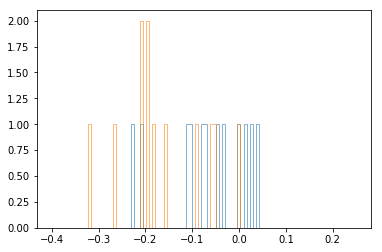

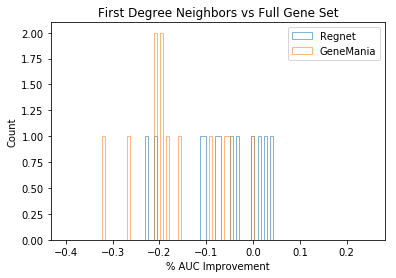

In [9]:

l1 = genemania_df['mean']
l2 = regnet_df['mean']

fig, ax = plt.subplots()
n1, bins1, patches1 = ax.hist(l1, range=(-.4, .25), bins=100, label="Regnet", 
                              density=0, alpha=0.55, histtype='step')
n1, bins1, patches1 = ax.hist(l2, range=(-.4, .25), bins=100, label="GeneMania", 
                              density=0, alpha=0.55, histtype='step')


fig, ax = plt.subplots()
n1, bins1, patches1 = ax.hist(l1, range=(-.4, .25), bins=100, label="Regnet", 
                              density=0, alpha=0.55, histtype='step')
n1, bins1, patches1 = ax.hist(l2, range=(-.4, .25), bins=100, label="GeneMania", 
                              density=0, alpha=0.55, histtype='step')

plt.title("First Degree Neighbors vs Full Gene Set")
plt.ylabel("Count")
plt.xlabel("% AUC Improvement")

plt.legend()
plt.show()